# Velocity analysis on murine MCs

In [16]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scvelo as scv
import scanpy.external as sce
import anndata as ad
from scipy.sparse import csr_matrix

PROJECT_DIR = "/home/sisaev/projects/Gustafsson_et_al_2022"
DATA_DIR = "/home/sisaev/data/thymus_Karin/count"
exec(open(f"{PROJECT_DIR}/tools/tools.py").read())

sc.settings.verbosity = 3
sns.set(font_scale=1)
sc.settings.set_figure_params(dpi=150)
sns.set_style("white")

Reds = get_beautiful_cmap()

paper_cmap = {
    "EC" : "#71fdea",
    "TEC A" : "#1d25f3",
    "TEC B" : "#dcae3d",
    "pcPV" : "#ae0b09",
    "aPV" : "#fda936",
    "Tuft cells" : "#a1fb73",
    "Lrrn4+" : "#f443a9",
    "MC" : "#6b04d4",
    "NC" : "#34be1e",
    "HC" : "#ff0000",
    "SM" : "#00573e",
    "Penk+ Cdh11+ MC" : "#00b3f4",
    "Cd248+ MC" : "#008af6",
    "Postn+ MC" : "#ed00ff"
}

In [4]:
adata = sc.read_h5ad(f"{PROJECT_DIR}/data/Mouse_MC_conos.h5ad")

control_samples = ["SCG_65", "SCG_MTH2_C", "SCG_MTH3_C", "SCG_MTH4_C"]
IL7_ko_samples = ["SCG_MTH3_IL7_C", "ID_MTH5_IL7_C", "SCG_MTH8_IL7_C1", "SCG_MTH8_IL7_C2"]
aged_samples = ["ID_MTH9_Old_M1", "ID_MTH9_Old_M2", "ID_MTH9_Old_F3", "ID_MTH9_Old_F4"]
IR_samples = ["SCG_MTH2_IR", "ID_MTH5_IR", "SCG_MTH7_IR"]
samples = control_samples + IL7_ko_samples + aged_samples + IR_samples

MC_clusters = ["Postn+ MC", "Penk+ Cdh11+ MC"] # Groups of interest

In [13]:
adata_velocity = {}

for sample in samples:
    # Read loom and select target cells
    adata_velocity[sample] = scv.read_loom(f"{DATA_DIR}/mouse/{sample}/velocyto/{sample}.loom")
    adata_velocity[sample].var_names_make_unique()
    adata_velocity[sample].obs.index = [barcode[:-1] for barcode in adata_velocity[sample].obs.index]
    _index = adata[adata.obs.sample_id == sample].obs.index
    adata_velocity[sample] = adata_velocity[sample][_index]

    # Get an annotation and UMAP coordinates
    adata_velocity[sample].obs["sample_id"] = sample
    adata_velocity[sample].obs["condition"] = adata[_index].obs["condition"]
    adata_velocity[sample].obs["cell_type_l2"] = adata[_index].obs["cell_type_l2"]
    adata_velocity[sample].obsm["X_umap"] = adata[_index].obsm["X_umap"].copy()
    adata_velocity[sample] = adata_velocity[sample][np.isin(adata_velocity[sample].obs["cell_type_l2"], MC_clusters)]

    # Standard pre-processing
    adata_velocity[sample].layers["counts"] = adata_velocity[sample].X.copy()
    scv.pp.normalize_per_cell(adata_velocity[sample])
    scv.pp.log1p(adata_velocity[sample])
    sc.pp.highly_variable_genes(
        adata_velocity[sample],
        n_top_genes=1000,
        flavor="seurat"
    )
    adata_velocity[sample].raw = adata_velocity[sample]
    adata_velocity[sample] = adata_velocity[sample][:, adata_velocity[sample].var.highly_variable]
    
    # Velocity
    scv.pp.moments(adata_velocity[sample])
    scv.tl.velocity_graph(adata_velocity[sample])
    scv.tl.recover_dynamics(adata_velocity[sample])
    scv.tl.velocity(adata_velocity[sample], mode="dynamical")
    scv.tl.velocity_embedding(adata_velocity[sample], basis="umap")
    
del _index

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/482 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/63 [00:00<?, ?gene/s]

    finished (0:00:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/224 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/85 [00:00<?, ?gene/s]

    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/541 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/64 [00:00<?, ?gene/s]

    finished (0:00:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1032 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/113 [00:00<?, ?gene/s]

    finished (0:00:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/579 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/77 [00:00<?, ?gene/s]

    finished (0:00:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/67 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/73 [00:00<?, ?gene/s]

    finished (0:00:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/182 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/67 [00:00<?, ?gene/s]

    finished (0:00:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/153 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/48 [00:00<?, ?gene/s]

    finished (0:00:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1560 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/148 [00:00<?, ?gene/s]

    finished (0:00:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1431 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/122 [00:00<?, ?gene/s]

    finished (0:00:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1055 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/194 [00:00<?, ?gene/s]

    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1256 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/177 [00:00<?, ?gene/s]

    finished (0:00:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1022 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/93 [00:00<?, ?gene/s]

    finished (0:00:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/1636 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/91 [00:00<?, ?gene/s]

    finished (0:00:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Normalized count data: X, spliced, unspliced.


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/56 cores)


  0%|          | 0/2281 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/56 cores)


  0%|          | 0/97 [00:00<?, ?gene/s]

    finished (0:00:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


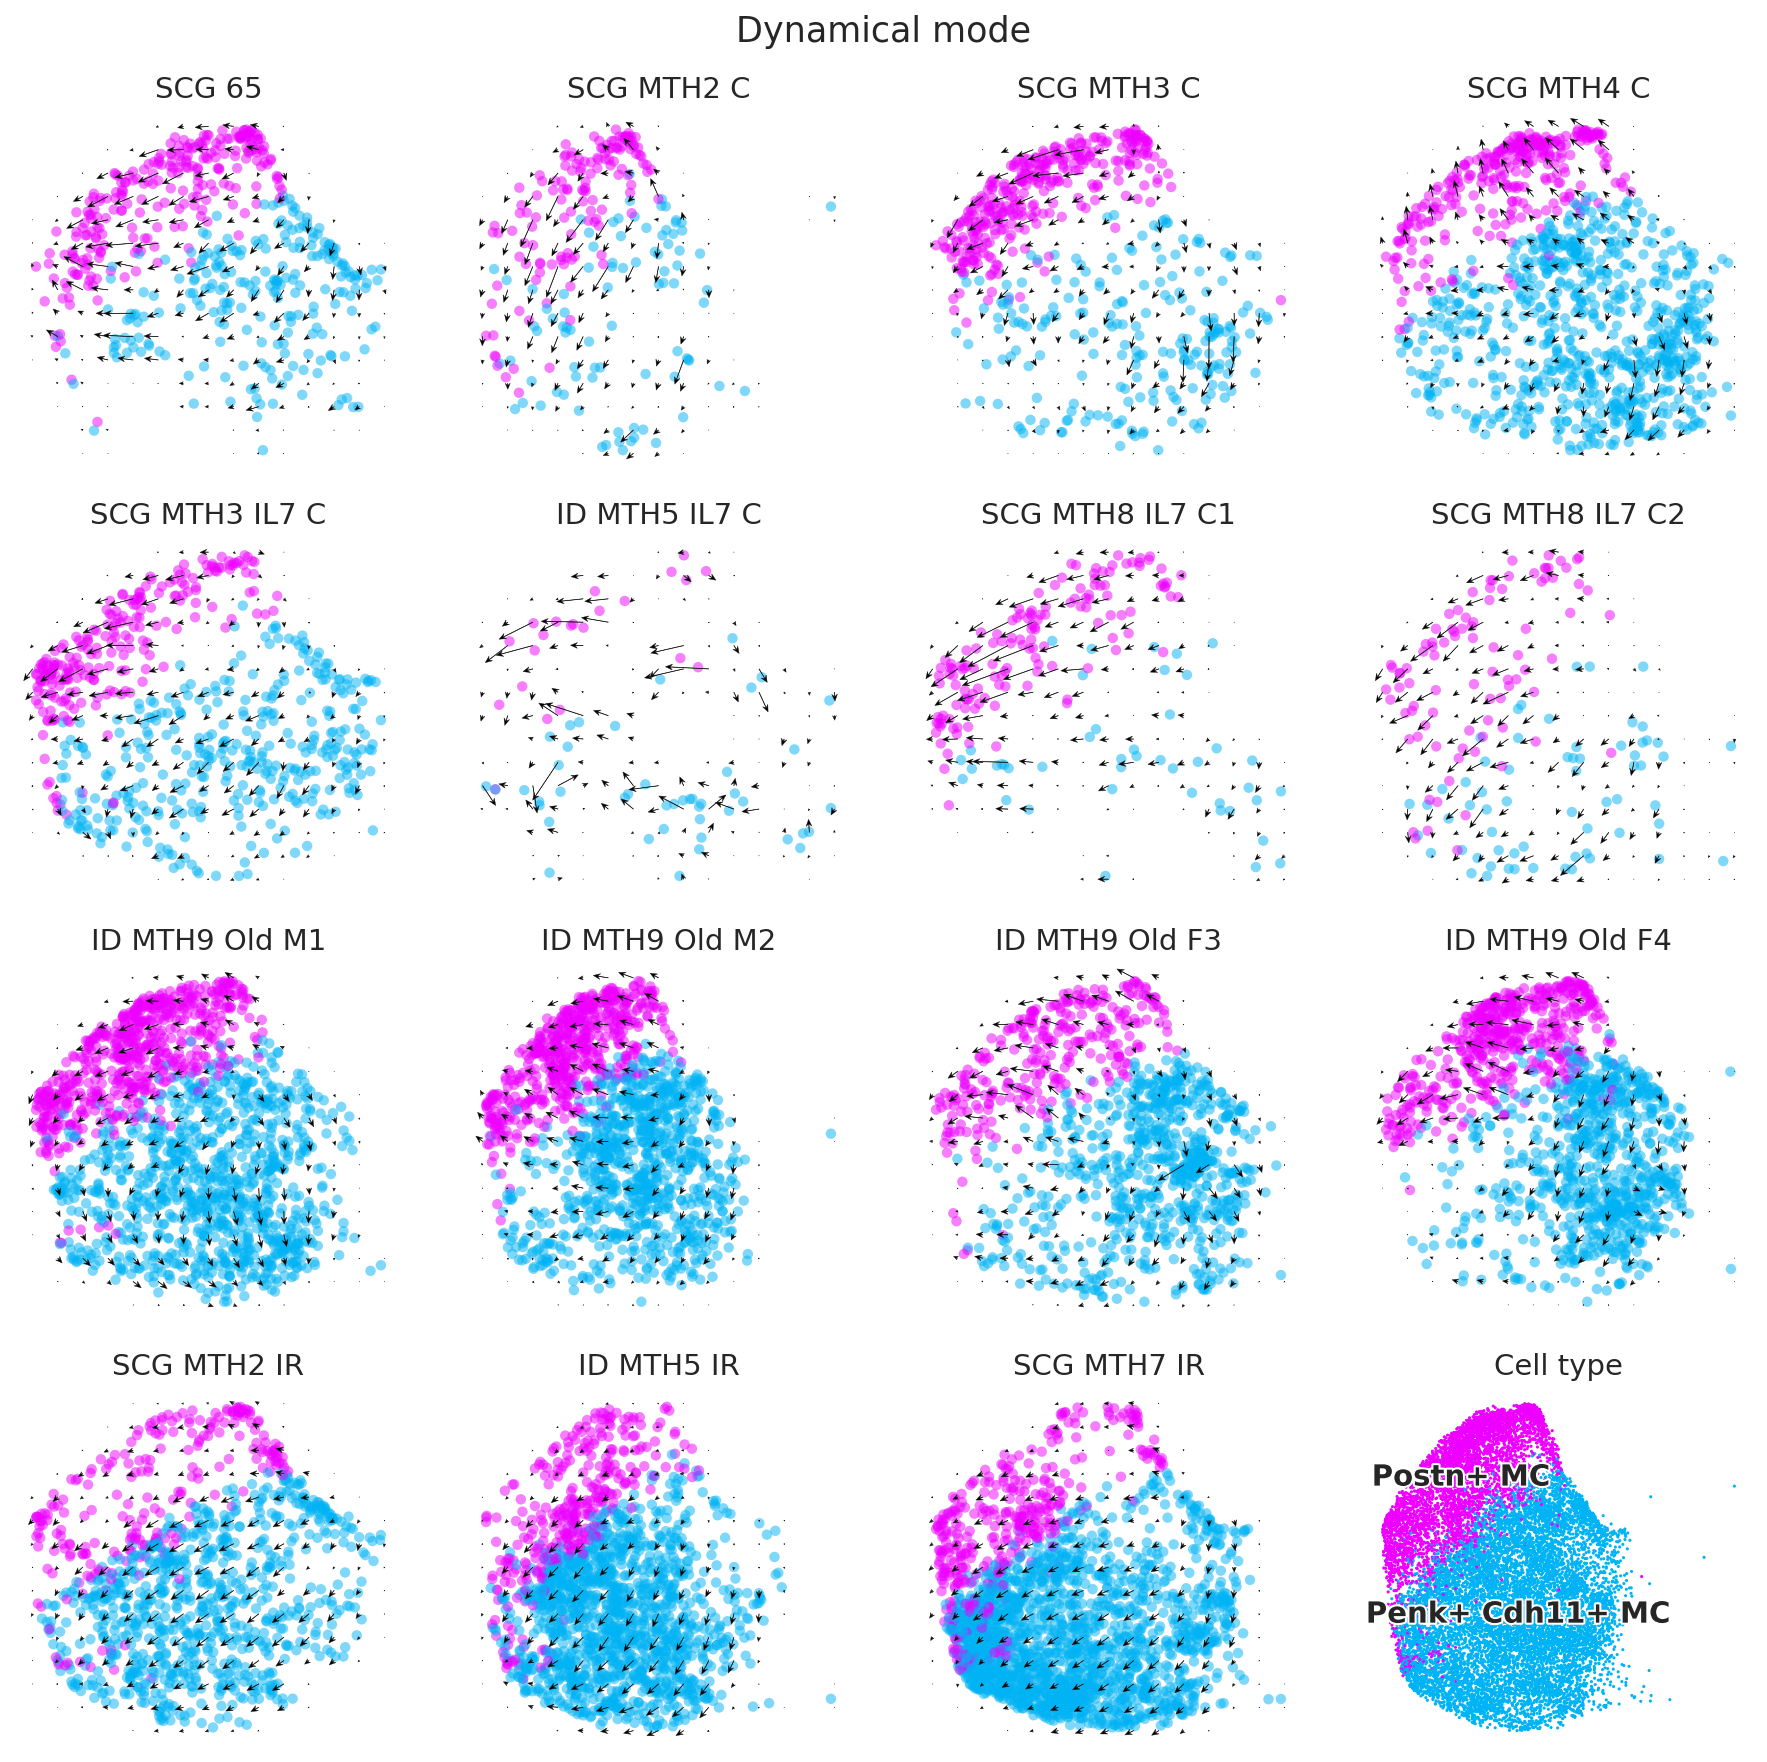

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=4, dpi=150, figsize=(12, 12))
i, j = 0, 0
for sample in samples:
    adata_velocity[sample].uns["cell_type_l2_colors"] = [paper_cmap[i] for i in adata_velocity[sample].obs.cell_type_l2.cat.categories]
    scv.pl.velocity_embedding_grid(adata_velocity[sample], color="cell_type_l2", s=100, alpha=0.5, legend_loc="right margin", title=sample,
                                   density=0.3, arrow_size=3, arrow_length=2.5, arrow_color="black", ax=axes[j, i], show=False)
    axes[j, i].get_legend().remove()
    i += 1
    if i >= 4:
        j += 1
        i = 0
        
sc.pl.umap(adata[np.isin(adata.obs["cell_type_l2"], MC_clusters)], color="cell_type_l2", legend_loc="on data",
           ax=axes[j, i], show=False, frameon=False, title="Cell type", legend_fontoutline=2)
fig.suptitle("Dynamical mode")
fig.tight_layout()

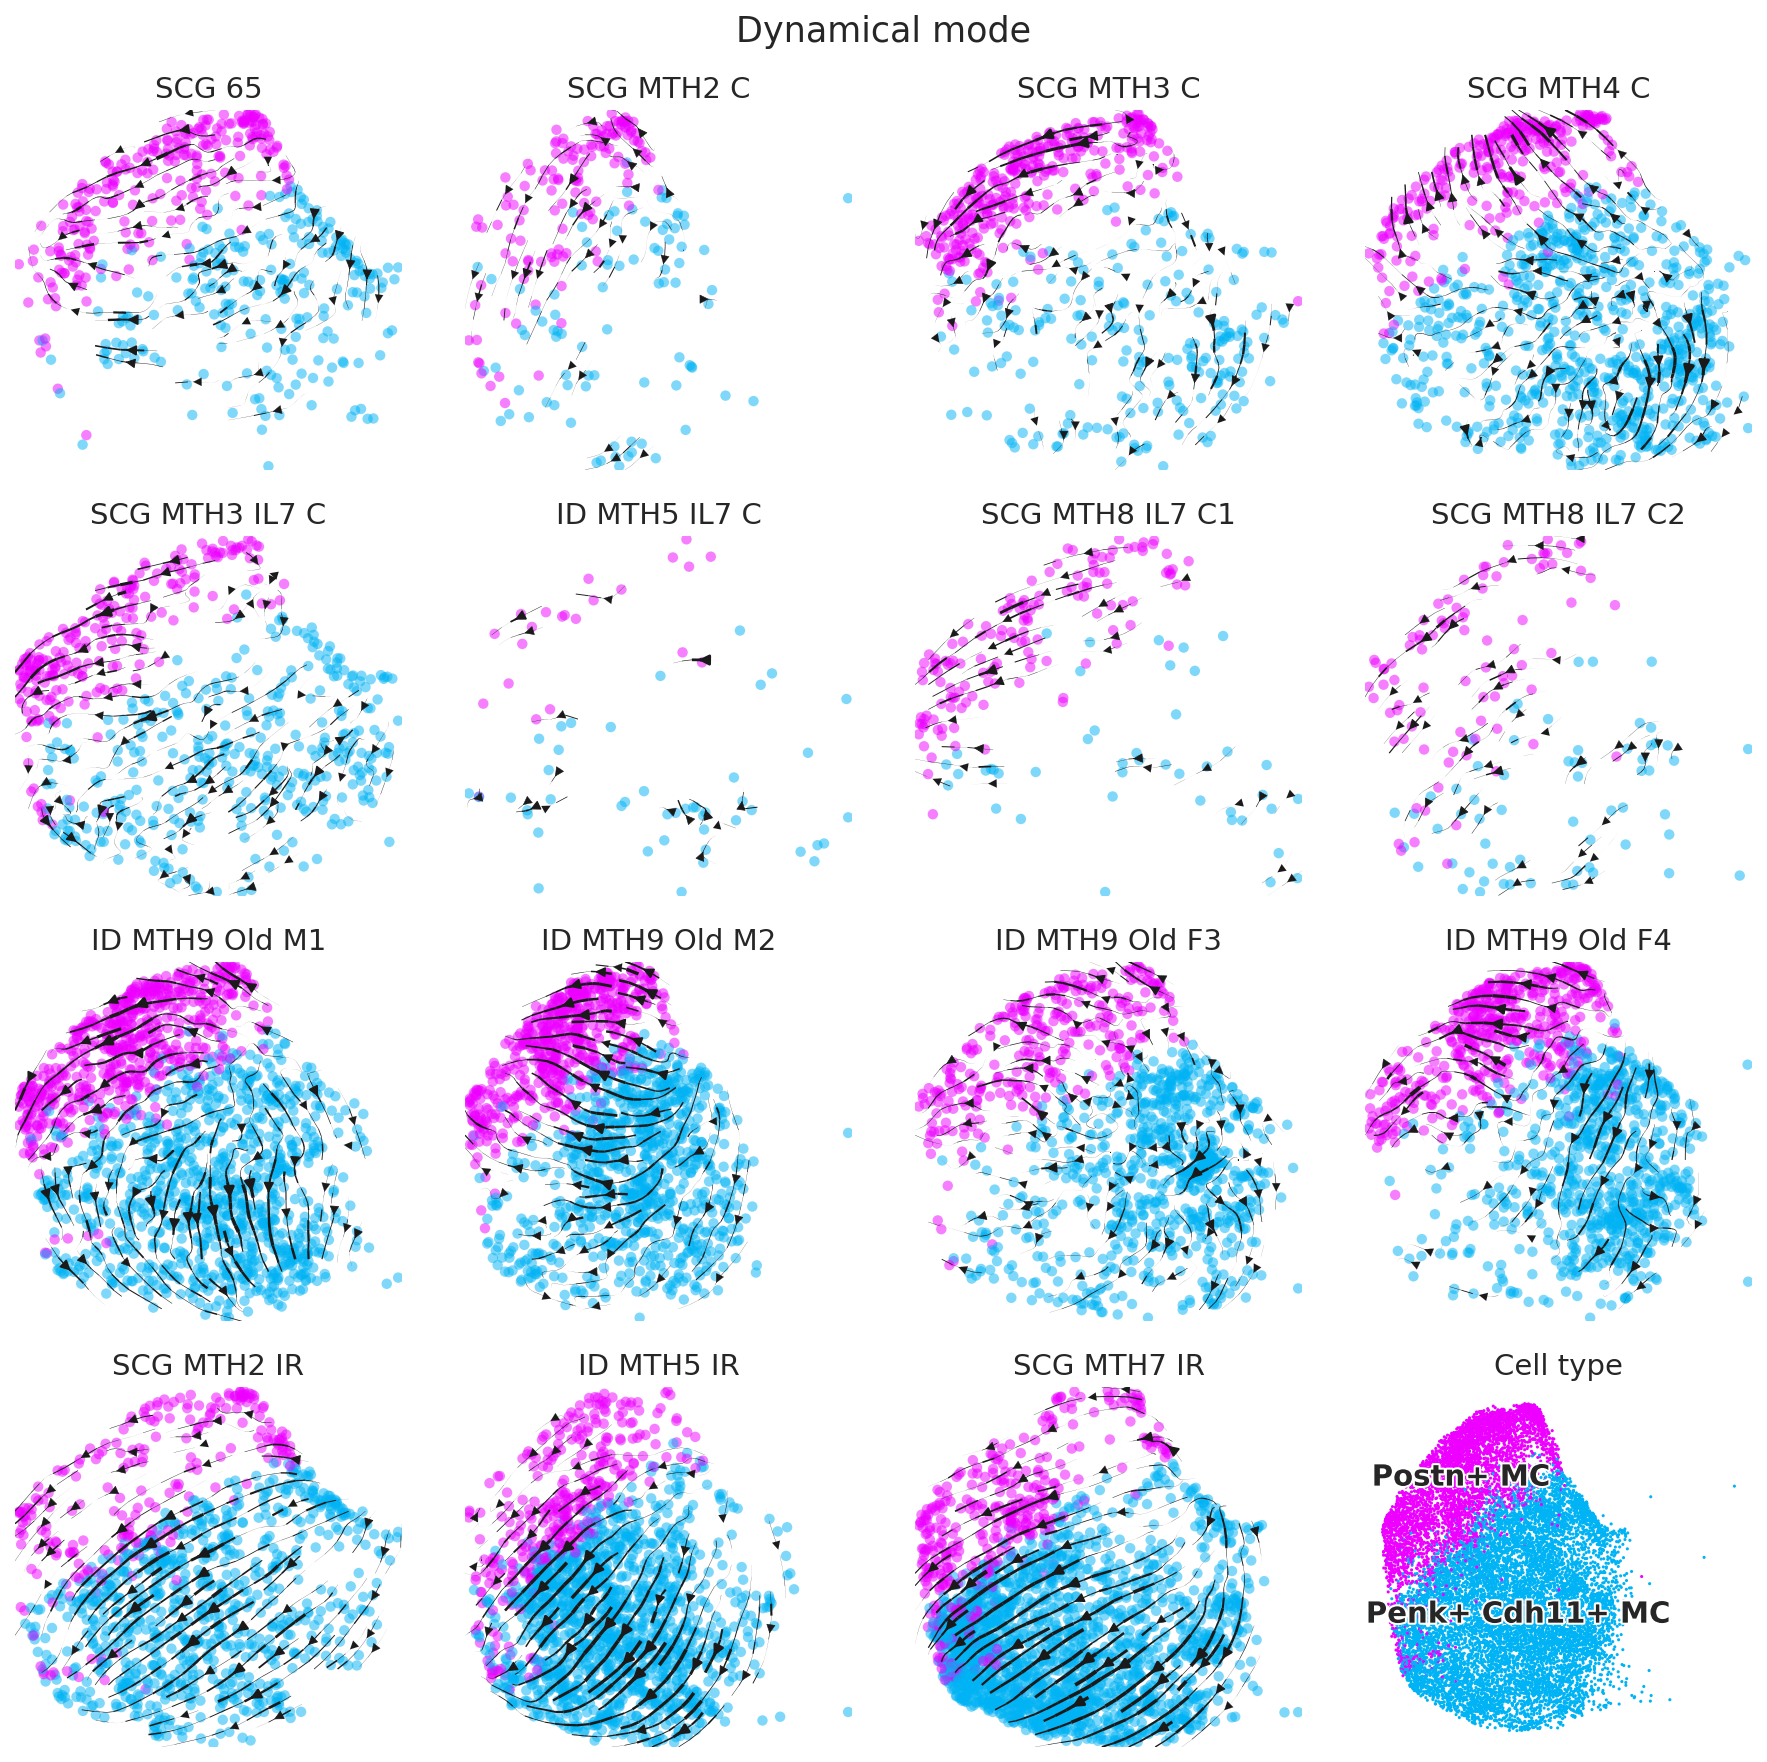

In [24]:
fig, axes = plt.subplots(ncols=4, nrows=4, dpi=150, figsize=(12, 12))
i, j = 0, 0
for sample in samples:
    adata_velocity[sample].uns["cell_type_l2_colors"] = [paper_cmap[i] for i in adata_velocity[sample].obs.cell_type_l2.cat.categories]
    scv.pl.velocity_embedding_stream(adata_velocity[sample], color="cell_type_l2", s=100, alpha=0.5, legend_loc="right margin", title=sample, ax=axes[j, i],
                                     show=False, density=1)
    axes[j, i].get_legend().remove()
    i += 1
    if i >= 4:
        j += 1
        i = 0
        
sc.pl.umap(adata[np.isin(adata.obs["cell_type_l2"], MC_clusters)], color="cell_type_l2", legend_loc="on data",
           ax=axes[j, i], show=False, frameon=False, title="Cell type", legend_fontoutline=2)
fig.suptitle("Dynamical mode")
fig.tight_layout()

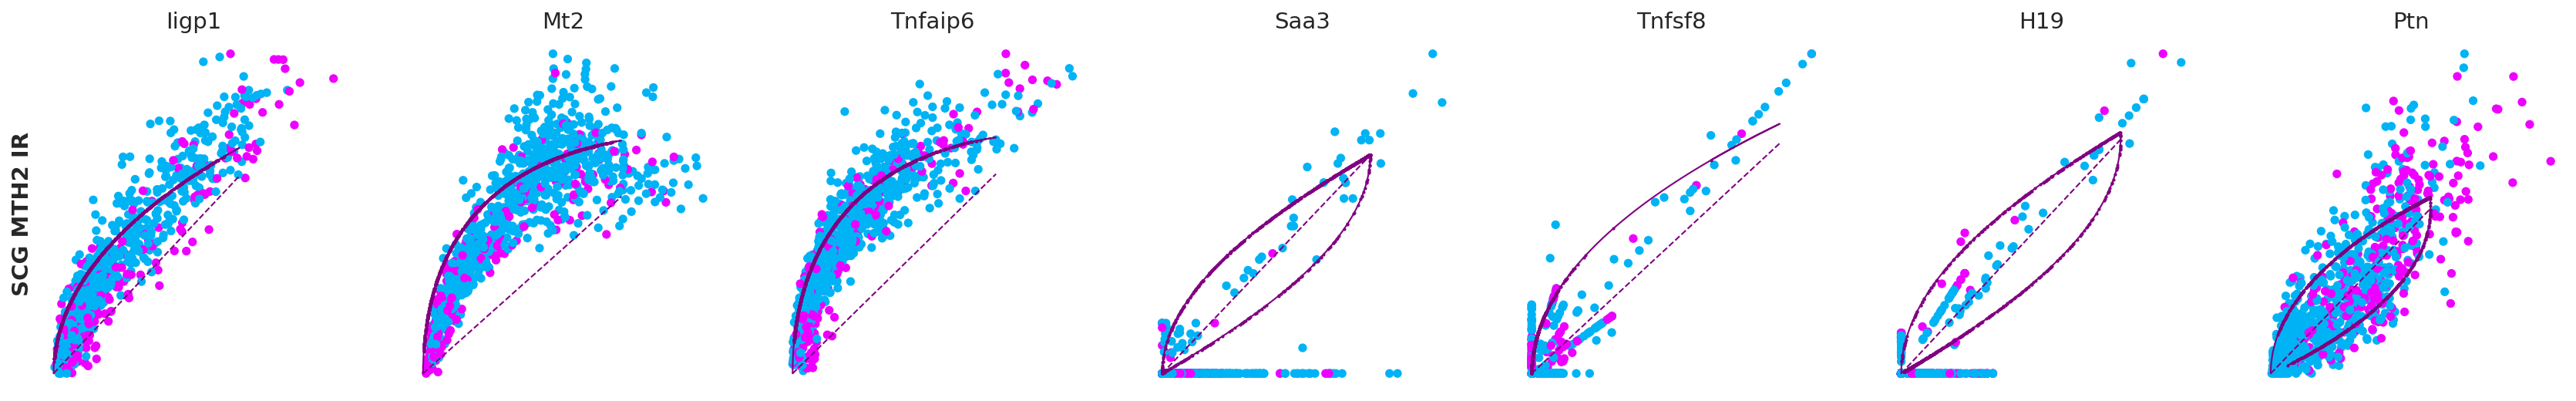

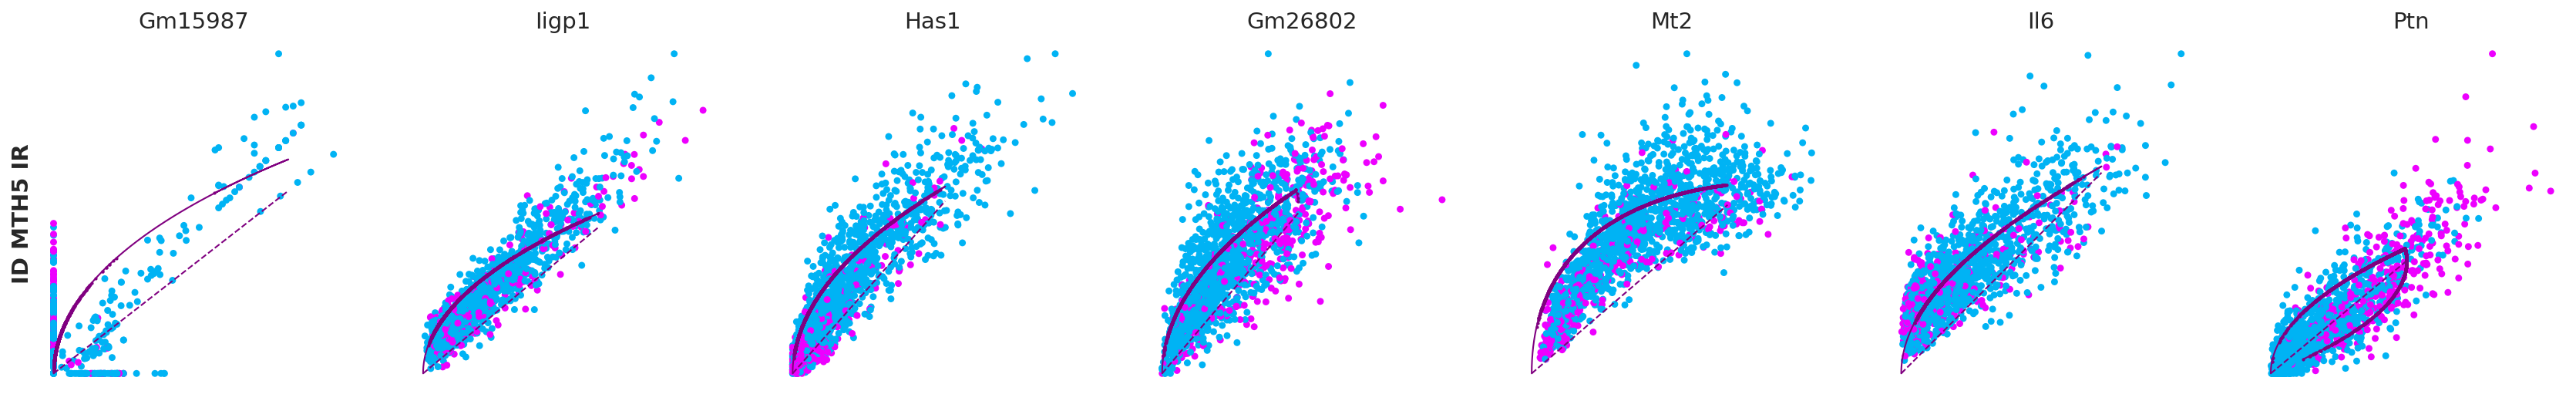

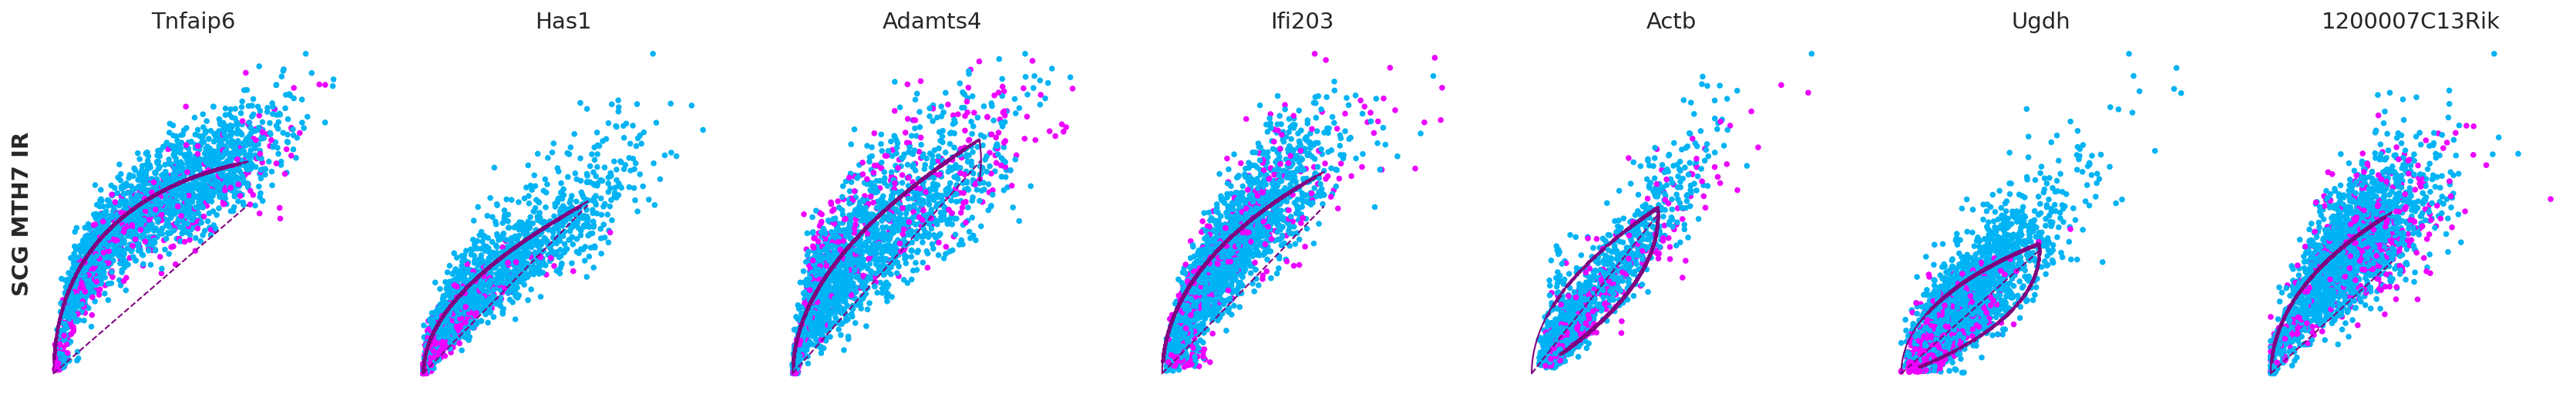

In [27]:
n_genes = 7
for sample in IR_samples:
    top_genes = adata_velocity[sample].var.fit_likelihood.sort_values(ascending=False).index
    scv.pl.scatter(adata_velocity[sample], basis=top_genes[:n_genes], ncols=n_genes, frameon=False, ylabel=sample, color="cell_type_l2")

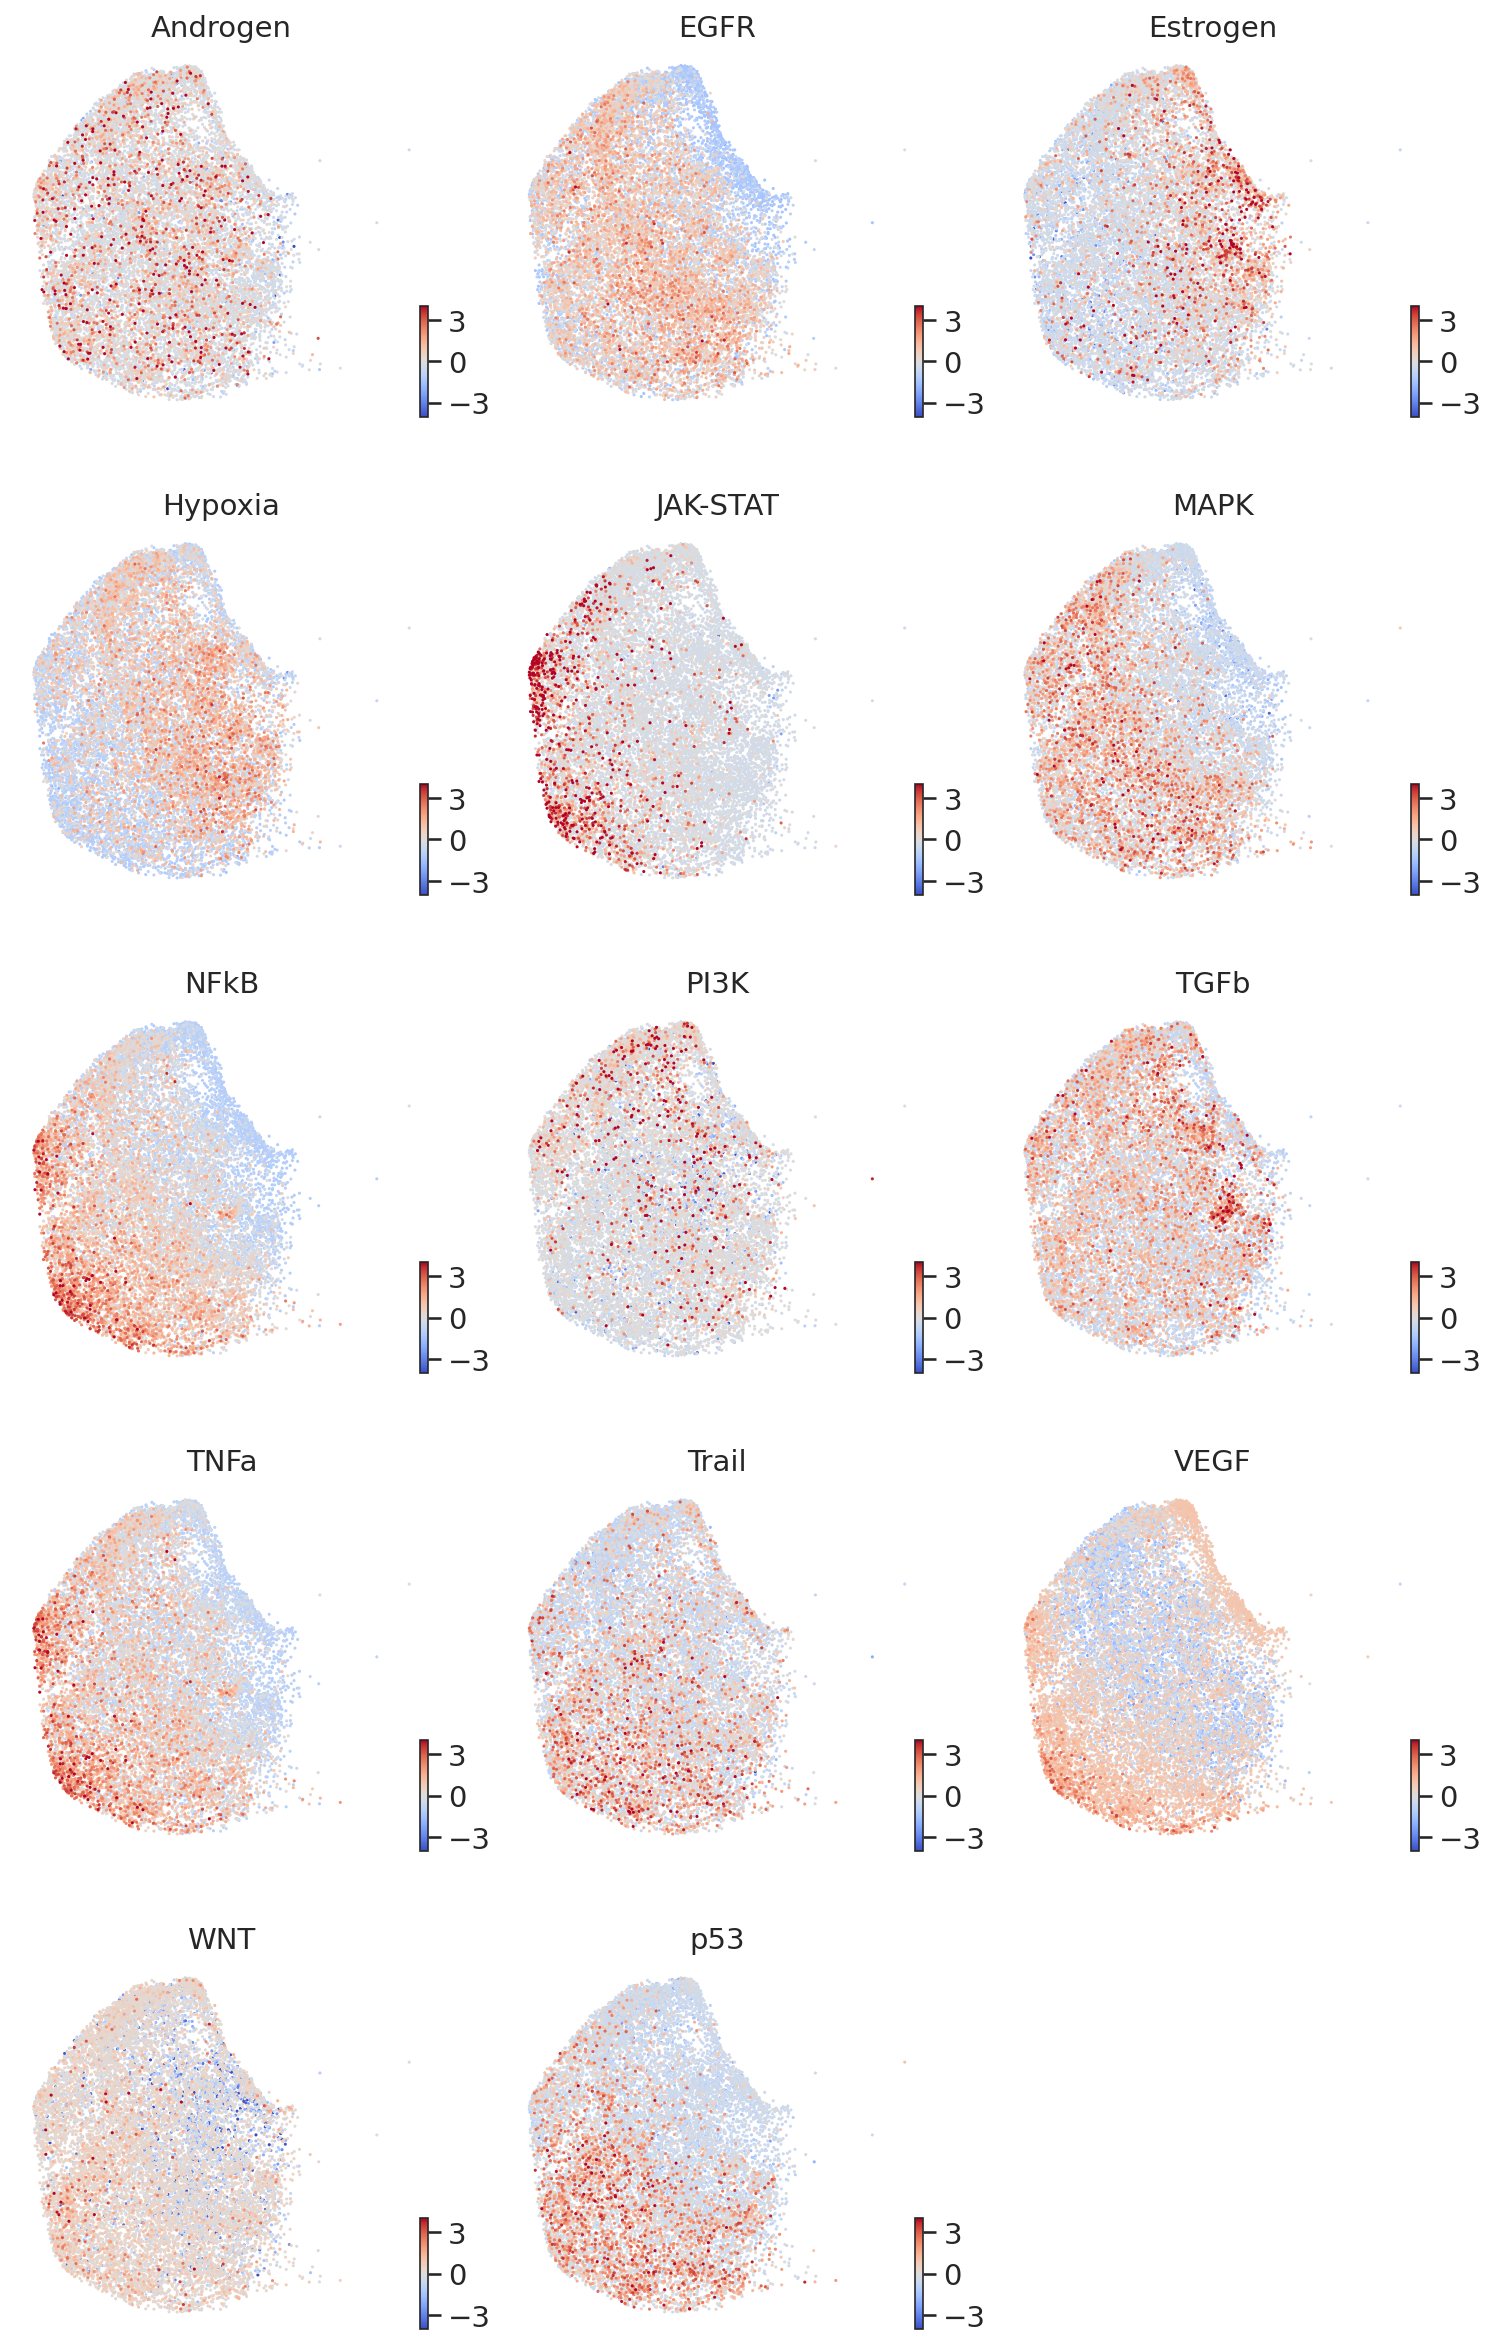

In [33]:
import progeny

adata_progeny = progeny.extract(adata[adata.obs.cell_type_l2 != "Cd248+ MC"])
scv.pl.umap(adata_progeny, color=adata_progeny.var.index, vmin=-4, vmax=4, cmap="coolwarm", ncols=3)